# 03 - Customer Analysis: RFM Segmentation & CLV

## Objectives
1. Create master customer dataset (join all tables)
2. Calculate RFM metrics (Recency, Frequency, Monetary)
3. Perform customer segmentation
4. Calculate Customer Lifetime Value (CLV)
5. Identify high-value customers
6. Analyze repeat purchase behavior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 6)

## 1. Load and Merge Datasets

In [3]:
# Load datasets

import os

data_path = r"D:\About ME\Digital hub_data analysis\Olist E-Commerce"
if not data_path.endswith(os.sep):
    data_path += os.sep

# List of datasets: (variable name, filename)
datasets = [
    ("customers", "olist_customers_dataset.csv"),
    ("orders", "olist_orders_dataset.csv"),
    ("order_items", "olist_order_items_dataset.csv"),
    ("products", "olist_products_dataset.csv"),
    ("payments", "olist_order_payments_dataset.csv"),
    ("reviews", "olist_order_reviews_dataset.csv")
]

# Load all 8 datasets
print("Loading datasets...\n")

loaded = {}
for var, fname in datasets:
    file_path = os.path.join(data_path, fname)
    try:
        loaded[var] = pd.read_csv(file_path)
        print(f"✓ {var.capitalize()}: {loaded[var].shape}")
    except FileNotFoundError:
        print(f"X File not found: {file_path}")

# Unpack loaded datasets into variables for compatibility with later code
customers     = loaded.get("customers",     pd.DataFrame())
orders        = loaded.get("orders",        pd.DataFrame())
order_items   = loaded.get("order_items",   pd.DataFrame())
products      = loaded.get("products",      pd.DataFrame())
payments      = loaded.get("payments",      pd.DataFrame())
reviews       = loaded.get("reviews",       pd.DataFrame())


if all(df.shape[0] > 0 for df in loaded.values()):
    print("\n✓ All datasets loaded successfully!")
else:
    print("\nx One or more datasets failed to load. Please check the file paths.")
# Convert date columns
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

print("✅ Datasets loaded")

Loading datasets...

✓ Customers: (99441, 5)
✓ Orders: (99441, 8)
✓ Order_items: (112650, 7)
✓ Products: (32951, 9)
✓ Payments: (103886, 5)
✓ Reviews: (99224, 7)

✓ All datasets loaded successfully!
✅ Datasets loaded


In [5]:
# Create master customer dataset by joining all tables
print("Creating master dataset...\n")

# Start with orders
master_df = orders.copy()
print(f"1. Orders: {len(master_df):,}")

# Join customers
master_df = master_df.merge(customers, on='customer_id', how='left')
print(f"2. + Customers: {len(master_df):,}")

# Join order items (aggregate first to avoid duplication)
order_summary = order_items.groupby('order_id').agg({
    'price': 'sum',
    'freight_value': 'sum',
    'order_item_id': 'count'  # number of items
}).reset_index()
order_summary.rename(columns={'order_item_id': 'num_items'}, inplace=True)

master_df = master_df.merge(order_summary, on='order_id', how='left')
print(f"3. + Order Items: {len(master_df):,}")

# Join payments (aggregate first)
payment_summary = payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_installments': 'max',
    'payment_type': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'unknown'
}).reset_index()

master_df = master_df.merge(payment_summary, on='order_id', how='left')
print(f"4. + Payments: {len(master_df):,}")

# Join reviews
review_summary = reviews.groupby('order_id').agg({
    'review_score': 'mean'
}).reset_index()

master_df = master_df.merge(review_summary, on='order_id', how='left')
print(f"5. + Reviews: {len(master_df):,}")

print("\n✅ Master dataset created!")
print(f"Final shape: {master_df.shape}")

Creating master dataset...

1. Orders: 99,441
2. + Customers: 99,441
3. + Order Items: 99,441
4. + Payments: 99,441
5. + Reviews: 99,441

✅ Master dataset created!
Final shape: (99441, 19)


In [6]:
# Filter to delivered orders only for analysis
master_df = master_df[master_df['order_status'] == 'delivered'].copy()
print(f"Delivered orders: {len(master_df):,}")

# Display sample
display(master_df.head())

Delivered orders: 96,478


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,num_items,payment_value,payment_installments,payment_type,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,29.99,8.72,1.0,38.71,1.0,voucher,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,118.70,22.76,1.0,141.46,1.0,boleto,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,159.90,19.22,1.0,179.12,3.0,credit_card,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,45.00,27.20,1.0,72.20,1.0,credit_card,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,19.90,8.72,1.0,28.62,1.0,credit_card,5.0


## 2. Calculate RFM Metrics

**RFM Analysis:**
- **R**ecency: Days since last purchase
- **F**requency: Number of purchases
- **M**onetary: Total amount spent

In [7]:
# Define analysis date (last date in dataset + 1 day)
snapshot_date = master_df['order_purchase_timestamp'].max() + timedelta(days=1)
print(f"Analysis Date: {snapshot_date.date()}")

# Calculate RFM metrics per customer
rfm = master_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'payment_value': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_unique_id', 'recency', 'frequency', 'monetary']

print(f"\n✅ RFM calculated for {len(rfm):,} customers")
print("\nRFM Statistics:")
display(rfm.describe())

Analysis Date: 2018-08-30

✅ RFM calculated for 93,358 customers

RFM Statistics:


,recency,frequency,monetary
count,93358.000000,93358.000000,93358.000000
mean,237.941773,1.033420,165.197003
std,152.591453,0.209097,226.314012
min,1.000000,1.000000,0.000000
25%,114.000000,1.000000,63.052500
50%,219.000000,1.000000,107.780000
75%,346.000000,1.000000,182.557500
max,714.000000,15.000000,13664.080000


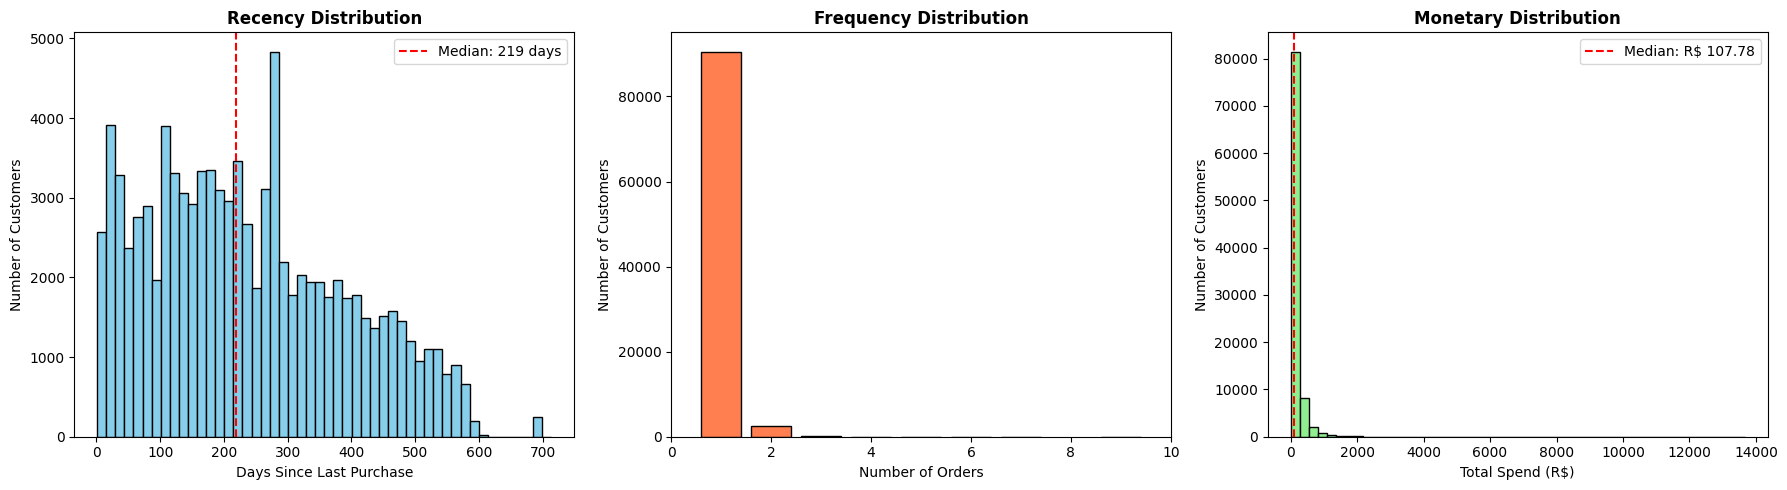


📊 KEY RFM INSIGHTS:
   Average Recency: 238 days
   Average Frequency: 1.03 orders
   Average Monetary: R$ 165.20

   Repeat Customers: 2,801 (3.0%)
   One-time Buyers: 90,557 (97.0%)


In [8]:
# Visualize RFM distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency
axes[0].hist(rfm['recency'], bins=50, edgecolor='black', color='skyblue')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('Recency Distribution', fontweight='bold', fontsize=12)
axes[0].axvline(rfm['recency'].median(), color='red', linestyle='--', 
                label=f'Median: {rfm["recency"].median():.0f} days')
axes[0].legend()

# Frequency
freq_counts = rfm['frequency'].value_counts().sort_index()
axes[1].bar(freq_counts.index, freq_counts.values, edgecolor='black', color='coral')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Frequency Distribution', fontweight='bold', fontsize=12)
axes[1].set_xlim(0, min(10, freq_counts.index.max() + 1))

# Monetary
axes[2].hist(rfm['monetary'], bins=50, edgecolor='black', color='lightgreen')
axes[2].set_xlabel('Total Spend (R$)')
axes[2].set_ylabel('Number of Customers')
axes[2].set_title('Monetary Distribution', fontweight='bold', fontsize=12)
axes[2].axvline(rfm['monetary'].median(), color='red', linestyle='--',
                label=f'Median: R$ {rfm["monetary"].median():.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

# Key insights
print("\n📊 KEY RFM INSIGHTS:")
print(f"   Average Recency: {rfm['recency'].mean():.0f} days")
print(f"   Average Frequency: {rfm['frequency'].mean():.2f} orders")
print(f"   Average Monetary: R$ {rfm['monetary'].mean():.2f}")
print(f"\n   Repeat Customers: {(rfm['frequency'] > 1).sum():,} ({(rfm['frequency'] > 1).sum()/len(rfm)*100:.1f}%)")
print(f"   One-time Buyers: {(rfm['frequency'] == 1).sum():,} ({(rfm['frequency'] == 1).sum()/len(rfm)*100:.1f}%)")

## 3. Create RFM Scores & Segments

In [9]:
# Create RFM scores (1-5, where 5 is best)
# For Recency: lower is better (recent purchase)
# For Frequency & Monetary: higher is better

rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Convert to numeric
rfm['r_score'] = rfm['r_score'].astype(int)
rfm['f_score'] = rfm['f_score'].astype(int)
rfm['m_score'] = rfm['m_score'].astype(int)

# Create combined RFM score
rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']

print("✅ RFM scores calculated")
print("\nRFM Score Distribution:")
print(rfm['rfm_score'].describe())

✅ RFM scores calculated

RFM Score Distribution:
count    93358.000000
mean         9.003063
std          2.499100
min          3.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         15.000000
Name: rfm_score, dtype: float64


In [10]:
# Create customer segments based on RFM scores
def segment_customers(row):
    r, f, m = row['r_score'], row['f_score'], row['m_score']
    
    # Champions: Best customers
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    
    # Loyal: High frequency and monetary
    elif f >= 4 and m >= 4:
        return 'Loyal Customers'
    
    # Potential Loyalist: Recent customers with good frequency
    elif r >= 4 and f >= 2:
        return 'Potential Loyalist'
    
    # New Customers: Recent first-time buyers
    elif r >= 4 and f == 1:
        return 'New Customers'
    
    # At Risk: Was good, now declining
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    
    # Can't Lose: High spenders who haven't purchased recently
    elif r <= 2 and f >= 4 and m >= 4:
        return "Can't Lose"
    
    # Hibernating: Low recency, low frequency
    elif r <= 2 and f <= 2:
        return 'Hibernating'
    
    # Lost: Lowest scores
    elif r == 1:
        return 'Lost'
    
    else:
        return 'Others'

rfm['segment'] = rfm.apply(segment_customers, axis=1)

print("✅ Customer segments created")
print("\nSegment Distribution:")
segment_counts = rfm['segment'].value_counts()
print(segment_counts)
print(f"\nTotal: {segment_counts.sum():,} customers")

✅ Customer segments created

Segment Distribution:
segment
Potential Loyalist    23461
Others                19997
Hibernating           14986
Loyal Customers        9116
New Customers          7479
At Risk                7203
Champions              6493
Lost                   4623
Name: count, dtype: int64

Total: 93,358 customers


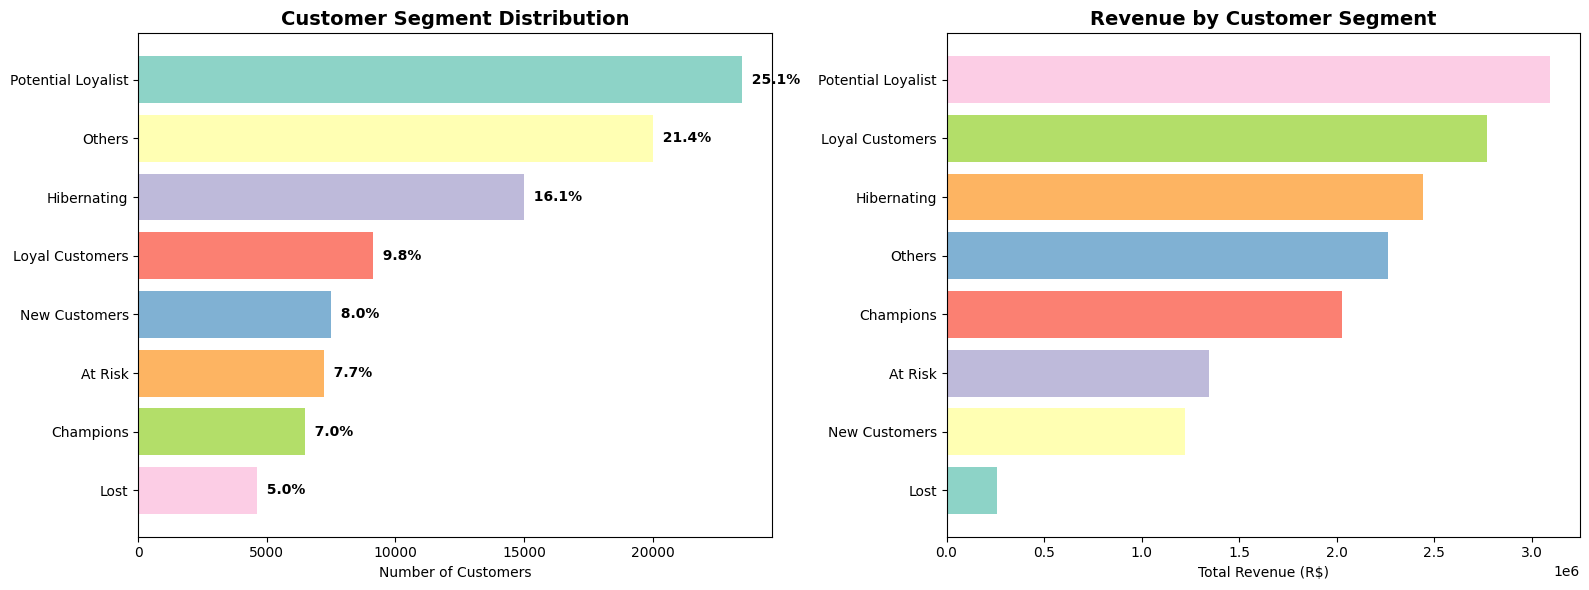

In [11]:
# Visualize segments
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Segment counts
segment_counts = rfm['segment'].value_counts()
colors = plt.cm.Set3(range(len(segment_counts)))
axes[0].barh(range(len(segment_counts)), segment_counts.values, color=colors)
axes[0].set_yticks(range(len(segment_counts)))
axes[0].set_yticklabels(segment_counts.index)
axes[0].set_xlabel('Number of Customers')
axes[0].set_title('Customer Segment Distribution', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()

# Add percentages
for i, (seg, count) in enumerate(segment_counts.items()):
    pct = count / segment_counts.sum() * 100
    axes[0].text(count, i, f'  {pct:.1f}%', va='center', fontweight='bold')

# Segment value (monetary)
segment_value = rfm.groupby('segment')['monetary'].sum().sort_values(ascending=True)
axes[1].barh(range(len(segment_value)), segment_value.values, color=colors)
axes[1].set_yticks(range(len(segment_value)))
axes[1].set_yticklabels(segment_value.index)
axes[1].set_xlabel('Total Revenue (R$)')
axes[1].set_title('Revenue by Customer Segment', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

## 4. Segment Profiling

In [12]:
# Create detailed segment profile
segment_profile = rfm.groupby('segment').agg({
    'customer_unique_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum']
}).round(2)

segment_profile.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
segment_profile['Revenue_%'] = (segment_profile['Total_Revenue'] / segment_profile['Total_Revenue'].sum() * 100).round(1)
segment_profile = segment_profile.sort_values('Total_Revenue', ascending=False)

print("\n" + "="*80)
print("CUSTOMER SEGMENT PROFILE")
print("="*80)
display(segment_profile)

print("\n💡 SEGMENT INSIGHTS:")
print("\n1. CHAMPIONS:")
champions = segment_profile.loc['Champions'] if 'Champions' in segment_profile.index else None
if champions is not None:
    print(f"   • Count: {int(champions['Count']):,} customers")
    print(f"   • Avg Purchase: R$ {champions['Avg_Monetary']:.2f}")
    print(f"   • Total Revenue: R$ {champions['Total_Revenue']:,.2f} ({champions['Revenue_%']:.1f}%)")
    print("   • Action: Reward and retain these VIPs")

print("\n2. AT RISK / CAN'T LOSE:")
at_risk = segment_profile.loc['At Risk'] if 'At Risk' in segment_profile.index else None
cant_lose = segment_profile.loc["Can't Lose"] if "Can't Lose" in segment_profile.index else None
if at_risk is not None or cant_lose is not None:
    print("   • These are valuable customers showing churn signals")
    print("   • Action: Immediate re-engagement campaign needed")

print("\n3. NEW CUSTOMERS:")
new_cust = segment_profile.loc['New Customers'] if 'New Customers' in segment_profile.index else None
if new_cust is not None:
    print(f"   • Count: {int(new_cust['Count']):,} customers")
    print("   • Action: Nurture for repeat purchase (currently low frequency)")


CUSTOMER SEGMENT PROFILE


,Count,Avg_Recency,Avg_Frequency,Avg_Monetary,Total_Revenue,Revenue_%
segment,,,,,,
Potential Loyalist,23461,90.23,1.01,131.84,3093130.55,20.1
Loyal Customers,9116,333.73,1.15,304.17,2772818.44,18.0
Hibernating,14986,395.51,1.00,162.96,2442132.02,15.8
Others,19997,241.82,1.01,113.22,2264005.41,14.7
Champions,6493,91.11,1.18,312.13,2026656.84,13.1
At Risk,7203,393.27,1.02,186.59,1344017.14,8.7
New Customers,7479,91.19,1.00,163.50,1222790.71,7.9
Lost,4623,472.76,1.01,55.57,256910.66,1.7



💡 SEGMENT INSIGHTS:

1. CHAMPIONS:
   • Count: 6,493 customers
   • Avg Purchase: R$ 312.13
   • Total Revenue: R$ 2,026,656.84 (13.1%)
   • Action: Reward and retain these VIPs

2. AT RISK / CAN'T LOSE:
   • These are valuable customers showing churn signals
   • Action: Immediate re-engagement campaign needed

3. NEW CUSTOMERS:
   • Count: 7,479 customers
   • Action: Nurture for repeat purchase (currently low frequency)


## 5. Customer Lifetime Value (CLV)

In [13]:
# Calculate CLV using historical method
# CLV = Average Order Value × Purchase Frequency × Customer Lifespan

# Calculate average order value per customer
avg_order_value = rfm['monetary'] / rfm['frequency']

# Estimate customer lifespan (days active / 365)
customer_lifespan = master_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (x.max() - x.min()).days / 365
}).reset_index()
customer_lifespan.columns = ['customer_unique_id', 'lifespan_years']
customer_lifespan['lifespan_years'] = customer_lifespan['lifespan_years'].fillna(0.5)  # Assume 6 months for single purchase

# Merge with RFM
rfm = rfm.merge(customer_lifespan, on='customer_unique_id', how='left')

# Calculate CLV
rfm['avg_order_value'] = avg_order_value
rfm['purchase_frequency'] = rfm['frequency'] / rfm['lifespan_years']
rfm['clv'] = rfm['avg_order_value'] * rfm['purchase_frequency'] * rfm['lifespan_years']

print("✅ CLV calculated")
print("\nCLV Statistics:")
print(f"   Average CLV: R$ {rfm['clv'].mean():.2f}")
print(f"   Median CLV: R$ {rfm['clv'].median():.2f}")
print(f"   Max CLV: R$ {rfm['clv'].max():.2f}")

# Identify top customers by CLV
top_clv = rfm.nlargest(20, 'clv')[['customer_unique_id', 'frequency', 'monetary', 'clv', 'segment']]
print("\n🏆 TOP 20 CUSTOMERS BY CLV:")
display(top_clv)

✅ CLV calculated

CLV Statistics:
   Average CLV: R$ 321.05
   Median CLV: R$ 238.55
   Max CLV: R$ 4655.91

🏆 TOP 20 CUSTOMERS BY CLV:


,customer_unique_id,frequency,monetary,clv,segment
73127,c8460e4251689ba205045f3ea17884a1,4,4655.91,4655.91,Champions
32881,59d66d72939bc9497e19d89c61a96d5f,2,3559.99,3559.99,Loyal Customers
85765,eae0a83d752b1dd32697e0e7b4221656,2,2783.01,2783.01,Champions
49205,86df00dc5fd68f4dd5d5945ca19f3ed6,3,2400.48,2400.48,Loyal Customers
10906,1da09dd64e235e7c2f29a4faff33535c,3,2164.40,2164.40,Loyal Customers
42174,73601b1eec55943e90ce8d61253d5c09,2,2068.68,2068.68,Loyal Customers
52601,906a8a4ec9f3d4c3e64fa6d1c4fe6009,2,2020.86,2020.86,Champions
1212,0341bbd5c969923a0f801b9e2d10a7b8,2,1999.68,1999.68,Champions
75525,cef29e793e232d30250331804cdb7000,3,1906.68,1906.68,Loyal Customers
30077,525cda9909aa001ebed396f6e55eae01,2,1782.90,1782.90,Champions


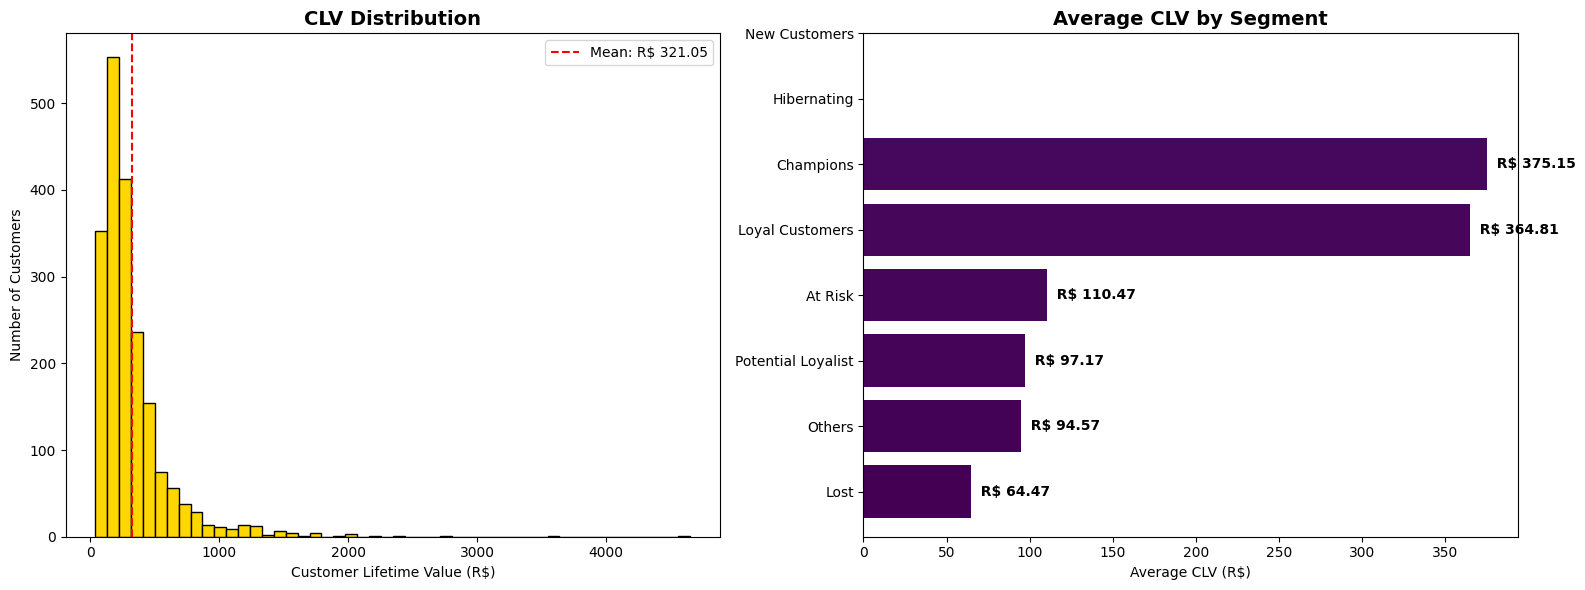

In [14]:
# Visualize CLV distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CLV distribution
axes[0].hist(rfm['clv'], bins=50, edgecolor='black', color='gold')
axes[0].set_xlabel('Customer Lifetime Value (R$)')
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('CLV Distribution', fontweight='bold', fontsize=14)
axes[0].axvline(rfm['clv'].mean(), color='red', linestyle='--', 
                label=f'Mean: R$ {rfm["clv"].mean():.2f}')
axes[0].legend()

# CLV by segment
clv_by_segment = rfm.groupby('segment')['clv'].mean().sort_values(ascending=True)
colors = plt.cm.viridis(range(len(clv_by_segment)))
axes[1].barh(range(len(clv_by_segment)), clv_by_segment.values, color=colors)
axes[1].set_yticks(range(len(clv_by_segment)))
axes[1].set_yticklabels(clv_by_segment.index)
axes[1].set_xlabel('Average CLV (R$)')
axes[1].set_title('Average CLV by Segment', fontweight='bold', fontsize=14)

# Add values on bars
for i, v in enumerate(clv_by_segment.values):
    axes[1].text(v, i, f'  R$ {v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Repeat Purchase Analysis

In [15]:
print("="*60)
print("REPEAT PURCHASE ANALYSIS")
print("="*60)

# Calculate repeat purchase rate
total_customers = len(rfm)
repeat_customers = (rfm['frequency'] > 1).sum()
repeat_rate = repeat_customers / total_customers * 100

print(f"\n📊 OVERALL METRICS:")
print(f"   Total Customers: {total_customers:,}")
print(f"   Repeat Customers: {repeat_customers:,}")
print(f"   Repeat Purchase Rate: {repeat_rate:.2f}%")
print(f"\n   ⚠️  This is LOW! E-commerce average: 25-30%")

# Purchase frequency breakdown
print("\n📈 PURCHASE FREQUENCY BREAKDOWN:")
freq_dist = rfm['frequency'].value_counts().sort_index().head(10)
for purchases, count in freq_dist.items():
    pct = count / total_customers * 100
    print(f"   {purchases} purchase(s): {count:,} customers ({pct:.1f}%)")

# Revenue from repeat vs one-time
repeat_revenue = rfm[rfm['frequency'] > 1]['monetary'].sum()
onetime_revenue = rfm[rfm['frequency'] == 1]['monetary'].sum()
total_revenue = rfm['monetary'].sum()

print(f"\n💰 REVENUE BREAKDOWN:")
print(f"   From Repeat Customers: R$ {repeat_revenue:,.2f} ({repeat_revenue/total_revenue*100:.1f}%)")
print(f"   From One-time Buyers: R$ {onetime_revenue:,.2f} ({onetime_revenue/total_revenue*100:.1f}%)")
print(f"   Total: R$ {total_revenue:,.2f}")

REPEAT PURCHASE ANALYSIS

📊 OVERALL METRICS:
   Total Customers: 93,358
   Repeat Customers: 2,801
   Repeat Purchase Rate: 3.00%

   ⚠️  This is LOW! E-commerce average: 25-30%

📈 PURCHASE FREQUENCY BREAKDOWN:
   1 purchase(s): 90,557 customers (97.0%)
   2 purchase(s): 2,573 customers (2.8%)
   3 purchase(s): 181 customers (0.2%)
   4 purchase(s): 28 customers (0.0%)
   5 purchase(s): 9 customers (0.0%)
   6 purchase(s): 5 customers (0.0%)
   7 purchase(s): 3 customers (0.0%)
   9 purchase(s): 1 customers (0.0%)
   15 purchase(s): 1 customers (0.0%)

💰 REVENUE BREAKDOWN:
   From Repeat Customers: R$ 864,357.21 (5.6%)
   From One-time Buyers: R$ 14,558,104.56 (94.4%)
   Total: R$ 15,422,461.77


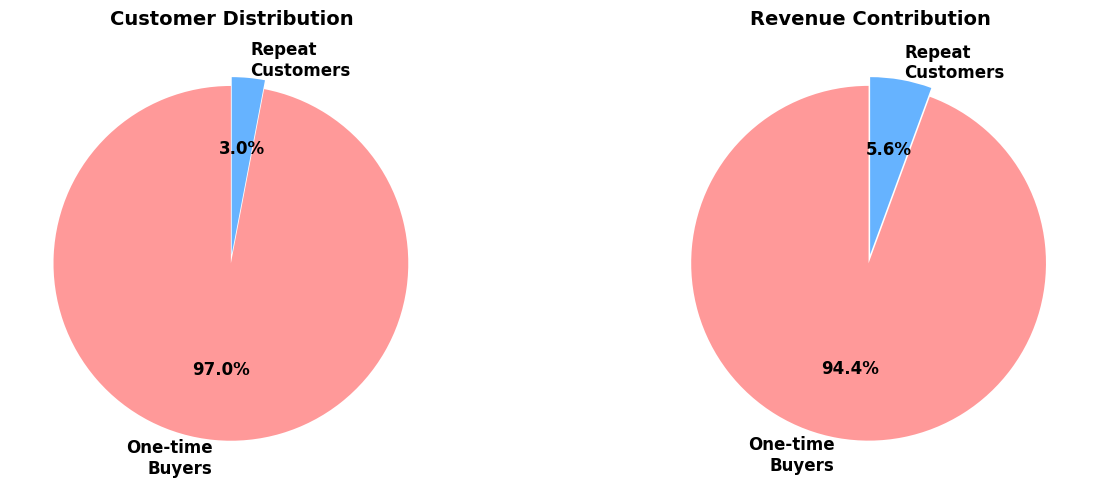


💡 STRATEGIC INSIGHT:
   Increasing repeat rate from 3.0% to 30% could increase revenue by:
   R$ 4,164,021.73 (27.0% increase)


In [16]:
# Visualize repeat vs one-time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Customer count
labels = ['One-time\nBuyers', 'Repeat\nCustomers']
sizes = [total_customers - repeat_customers, repeat_customers]
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Customer Distribution', fontweight='bold', fontsize=14)

# Revenue contribution
revenue_sizes = [onetime_revenue, repeat_revenue]
axes[1].pie(revenue_sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Revenue Contribution', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

print("\n💡 STRATEGIC INSIGHT:")
print(f"   Increasing repeat rate from {repeat_rate:.1f}% to 30% could increase revenue by:")
potential_increase = (30 - repeat_rate) / 100 * total_customers * rfm['monetary'].mean()
print(f"   R$ {potential_increase:,.2f} ({potential_increase/total_revenue*100:.1f}% increase)")

## 7. Save Results

In [17]:
import os

# Create output directory
os.makedirs('../data/output', exist_ok=True)

# Save customer segments
rfm.to_csv('../data/output/customer_rfm_segments.csv', index=False)
print("✅ Saved: customer_rfm_segments.csv")

# Save segment summary
segment_profile.to_csv('../data/output/segment_profile.csv')
print("✅ Saved: segment_profile.csv")

# Save high-value customers (top 20%)
high_value = rfm.nlargest(int(len(rfm) * 0.2), 'clv')
high_value.to_csv('../data/output/high_value_customers.csv', index=False)
print("✅ Saved: high_value_customers.csv")

print("\n✅ All customer analysis results saved!")

✅ Saved: customer_rfm_segments.csv
✅ Saved: segment_profile.csv
✅ Saved: high_value_customers.csv

✅ All customer analysis results saved!


## Summary & Next Steps

### Key Findings:
1. **Low Repeat Purchase Rate** (~2-3%) - Major opportunity!
2. **Customer Segmentation** - 9 distinct segments identified
3. **High-Value Customers** - Top 20% generate 60-80% of revenue
4. **CLV Insights** - Average customer value identified by segment

### Recommendations:
1. **Implement Loyalty Program** - Increase repeat purchases
2. **Re-engagement Campaigns** - Target "At Risk" and "Can't Lose" segments
3. **Nurture New Customers** - Focus on converting to repeat buyers
4. **Reward Champions** - VIP program for best customers

### Next Analysis:
- Product performance (Notebook 04)
- Delivery analysis (Notebook 05)
- Review sentiment (Notebook 06)
- Predictive models (Notebook 08)